In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

### Code copied from [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)
### Usage of [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [2]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

In [18]:
def visualize_data(data):
    points = data
    plt.scatter(points[:, 0], points[:, 1])
    plt.show()

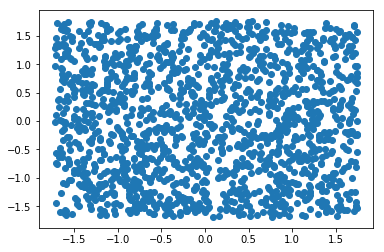

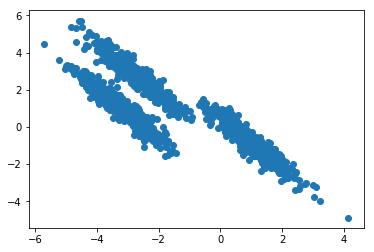

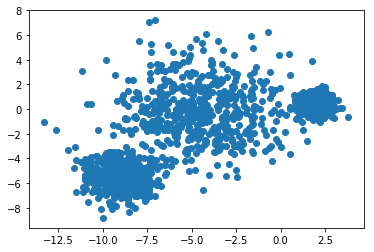

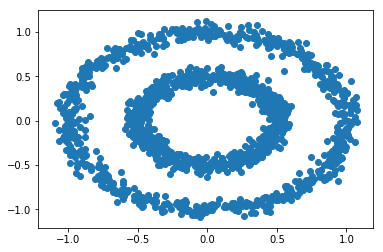

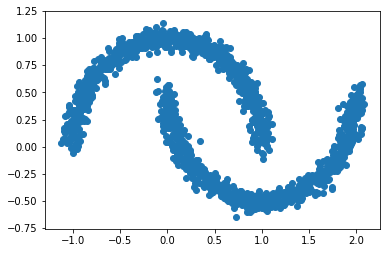

In [29]:
visualize_data(X)
visualize_data(X_aniso)
visualize_data(varied[0])
visualize_data(noisy_circles[0])
visualize_data(noisy_moons[0])

{'xi': 0.25, 'quantile': 0.2, 'preference': -240, 'damping': 0.77, 'min_samples': 20, 'n_clusters': 2}
{'damping': 0.75, 'n_clusters': 2, 'preference': -220}
{'eps': 0.18, 'min_cluster_size': 0.2, 'min_samples': 5, 'xi': 0.035, 'n_neighbors': 2}
{'eps': 0.15, 'min_cluster_size': 0.2, 'min_samples': 20, 'xi': 0.1, 'n_neighbors': 2}
{}
{}


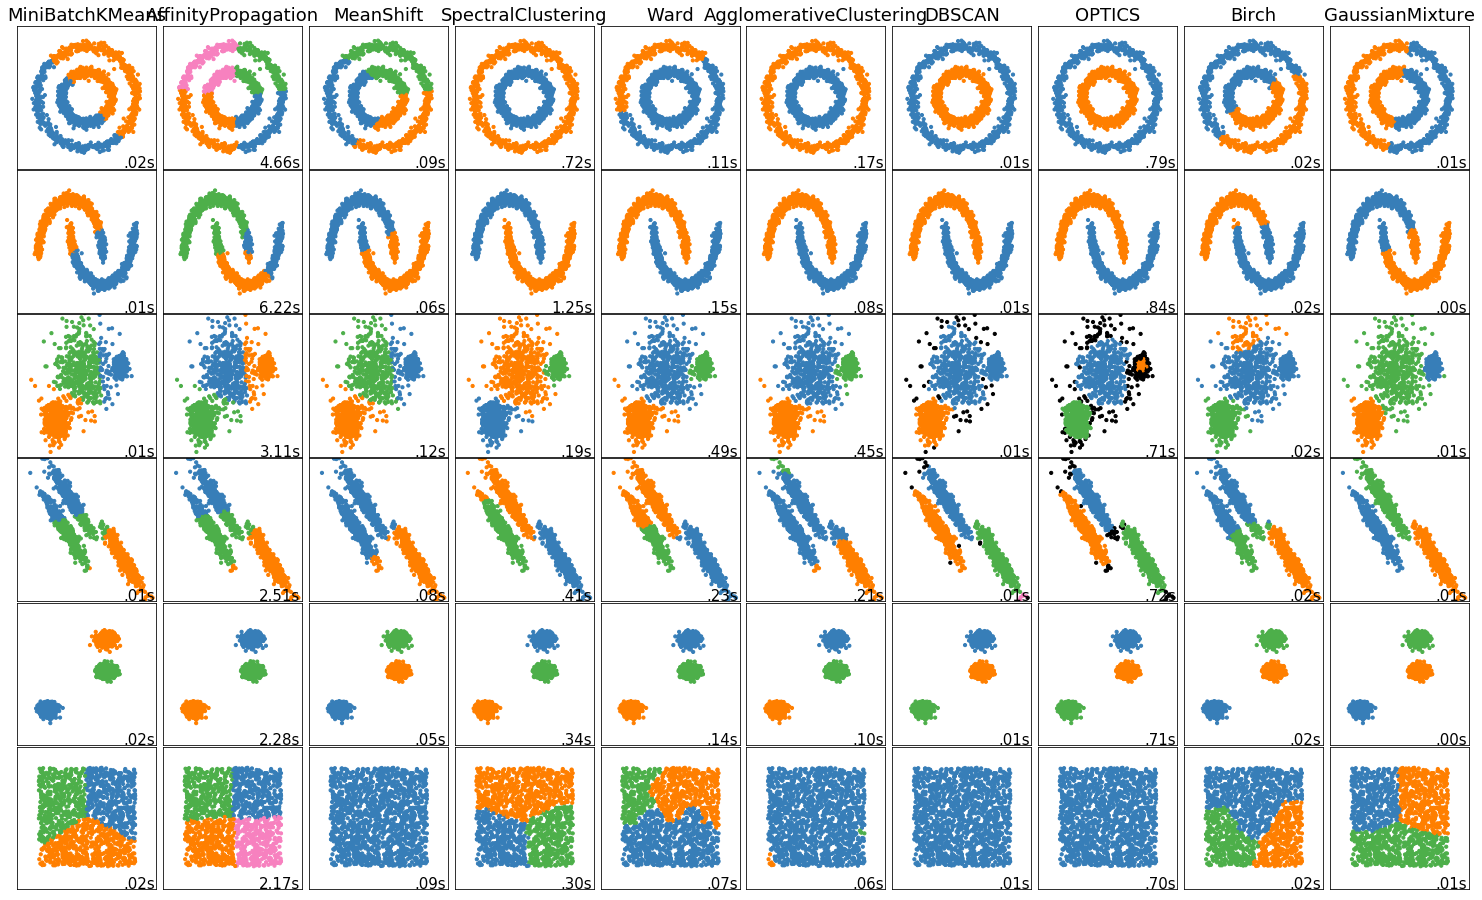

In [26]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)
    print(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

### Testing DBSCAN clustering algorithm

In [120]:
dataset = noisy_moons

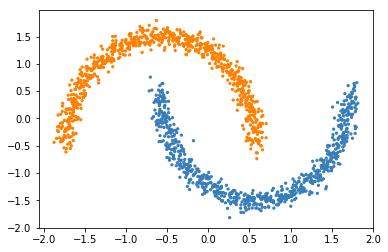

In [121]:
X, y = dataset
X = StandardScaler().fit_transform(X)
algorithm = cluster.DBSCAN(eps=0.2)
algorithm.fit(X)

if hasattr(algorithm, 'labels_'):
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(X)
    
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))    
plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
plt.show()

### How to evaluate a clustering result?

In [122]:
from sklearn import metrics

In [123]:
# Silhouette coefficient
print(metrics.silhouette_score(X, y_pred, metric='euclidean'))

# Calinski Harabasz score
print(metrics.calinski_harabasz_score(X, y_pred))

# Davies-Bouldin Index
print(metrics.davies_bouldin_score(X, y_pred))

0.3891199513969138
1299.6422322906212
1.0230868386830776


- Silhouette coefficient: higher better
- Calinski Harabasz score: higher better
- Davies-Bouldin Index: lower better

### What is 'cycle' and 'islice'

In [124]:
colors 

array(['#377eb8', '#ff7f00'], dtype='<U7')

In [125]:
for i in islice(cycle(['a', 'b', 'c']), 5):
    print(i)

a
b
c
a
b


In [126]:
colors[[1, 1, 0, 0]]

array(['#ff7f00', '#ff7f00', '#377eb8', '#377eb8'], dtype='<U7')

### Testing Gaussian Mixture Model

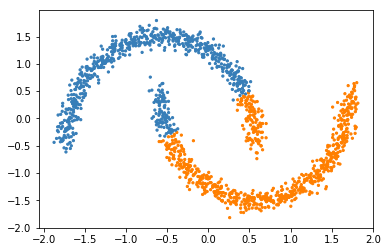

In [127]:
X, y = dataset
X = StandardScaler().fit_transform(X)
algorithm = mixture.GaussianMixture(n_components=2, covariance_type='full')
algorithm.fit(X)

if hasattr(algorithm, 'labels_'):
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(X)
    
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    
plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
plt.show()

In [128]:
# Silhouette coefficient
print(metrics.silhouette_score(X, y_pred, metric='euclidean'))

# Calinski Harabasz score
print(metrics.calinski_harabasz_score(X, y_pred))

# Davies-Bouldin Index
print(metrics.davies_bouldin_score(X, y_pred))

0.4997331015018269
2111.6847239228446
0.8043022148439296


### Conclusion

- Silhouette coefficient, Calinski Harabasz score, and Davies-Bouldin Index do not do a good job at evaluating clustering results
- These metrics favor convex based clustering algorithms, and do not favor density based clustering algorithms
- Is this a problem we need to solve? Maybe no. 